# World Data League 2021
## **Identifying road segments with potential safety hazard**

## Context

According to the 2017 UN’s Global Mobility Report, “road transport claims the bulk of transport-related fatalities worldwide: it accounts for 97 per cent of the deaths and 93 percent of the costs. On roads, the fatality risk for motorcyclists is 20 times higher than for car occupants, followed by cycling and walking, with 7 to 9 times higher risk than car travel, respectively. Bus occupants are 10 times safer than car occupants. Rail and air are the safest transport modes.”

So, decision agents must know where to “improve the safety of mobility across all modes of transport by avoiding fatalities, injuries, and crashes from transport mishaps”.

That is why creating a model that identifies areas or roads with more considerable risks will help where to invest in road safety and which actions are needed.

The goal is not to predict accidents. Instead, it is to identify hazardous roads, so decision agents take measures on where they need to act on their cities to improve road safety.

## Goals

Understand which areas of the city of Porto and/or Lisbon are riskier.

## Outcome

A heatmap or intensity model that considers traffic intensity data, characteristics of road segments and their speed profile. This heatmap should identify the most conflictive areas or roads.

## **1. Introduction**

A quick search online yielded no results for data on the amount of accidents for portuguese roads. This means that our focus should be supported by scientific evidence. We started by doing a literature review of the work already done in this area so we can then extract some metrics to evaluate safety hazard in each road.

## Literature Review

So in order to perform this analysis we will start by reviewing some literature to get some scientific support to our work here. Here are some conclusions:

*  Traffic volume is the leading factor in road accidents for South Korea[1];
*  56% of accidents occur by the infringement of safety driving violations[1];
* Population density is associated with the accidents frequency and lower density results in an increased number of accidents;
*  One criteria to evaluate road segments is geometry of the road (curves, intersections,etc...). This has been evaluated in a qualitative way [2][3], but we can use geographical information to extract quantitative values about this;
* Taking a left turn is an important accident factor when having an accident. The same paper suggest the use of roundabouts to reduce accidents in "black zones" of accidents[4];
* Rainy conditions and slipery roads also contribute to accidents[4];
* In freeways factors for accidents usually are caused by inappropriate speed and/or behavior of the driver[4];
* There is no unique combination of characteristics associated to road accident occurrences: it is a complex phenomenon for which only some aspects are reported here[4].

---
[1] Ashraf I, Hur S, Shafiq M, Park Y (2019) Catastrophic factors involved in road accidents: Underlying causes and descriptive analysis. PLoS ONE 14(10): e0223473. https://doi.org/10.1371/journal.pone.0223473  
[2] Stević, Željko & Pamucar, Dragan & Subotić, Marko & Antucheviciene, Jurgita & Zavadskas, Edmundas. (2018). The Location Selection for Roundabout Construction Using Rough BWM-Rough WASPAS Approach Based on a New Rough Hamy Aggregator. Sustainability. 10. 10.3390/su10082817.   
[3] Nenadić, D. (2019). Ranking dangerous sections of the road using MCDM model. Decision Making: Applications in Management and Engineering, 2(1), 115-131. https://doi.org/10.31181/dmame1901115n  
[4] Geurts, Karolien, Isabelle Thomas, and Geert Wets. “Understanding Spatial Concentrations of Road Accidents Using Frequent Item Sets.” Accident Analysis & Prevention 37, no. 4 (July 1, 2005): 787–99. https://doi.org/10.1016/j.aap.2005.03.023.



## Metrics to obtain

Before we measure the road risk, we have to define the metrics we are going to be extracting for each of the road segments. We selected the following:

1. Using traffic volume is a must (we have that data already);
2. Population density data in each road segment (the literature said that lower density means higher number of accidents, it might be interesting to analyze, but might be a correlation because of a decrease in safety measures);
3. if the road has roundabouts;
4. Rainfall per day;
5. By what proportion does the third quartile of velocity exceeds the upper bound of the speed category. 
6. if the median also exceeds speed category.

## Heatmap creation

To create the heatmap, we will have to use our own criteria to evaluate the road risk.

The function will make use of weights assigned to each variable accordingly. All data is normalized before applying the weights. This allows us to be transparent on the importance we are providing to each of the variables.

## **2. Development**

## Initialization

To start we will load the data and visualize it in a map.

In [3]:
# Mount
# Go into Google Drive to get the data

from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)
%cd gdrive/
%cd My Drive
%cd WDL 
%cd WDL Project 2

Mounted at /content/gdrive/
/content/gdrive
/content/gdrive/My Drive
[Errno 2] No such file or directory: 'WDL'
/content/gdrive/My Drive
/content/gdrive/My Drive/WDL Project 2


In [3]:
!pip install geopandas -q
!pip install contextily -q
!pip install osmnx -q

     |████████████████████████████████| 1.0MB 6.5MB/s 
     |████████████████████████████████| 6.5MB 19.5MB/s 
     |████████████████████████████████| 15.3MB 276kB/s 
     |████████████████████████████████| 19.1MB 51.7MB/s 
     |████████████████████████████████| 92kB 4.0MB/s 
     |████████████████████████████████| 1.0MB 10.9MB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 10.3MB 29.3MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [96]:
import geopandas as gpd
import pandas as pd
from datetime  import datetime
import osmnx as ox
import contextily as ctx
import networkx as nx
import osmnx as ox
from shapely.geometry import MultiPoint, Point
from matplotlib import pyplot as plt

In [4]:
risk_roads = gpd.read_file('data/m_risk_prfile.json')
risk_roads.head()

,Link_ID,linkid,Daily_Aver,Average_Ve,Median_of_,First_Quar,Third_Quar,Func_Class,Speed_Cat,geometry
0,80216819,80216819,6224.778569,45.208716,44.464286,28.000000,59.00,2,6,"LINESTRING (-9.16402 38.77030, -9.16389 38.770..."
1,80216858,80216858,2236.054168,79.563308,82.750000,71.750000,93.25,2,4,"LINESTRING (-9.16645 38.74274, -9.16638 38.742..."
2,80216859,80216859,2138.725039,65.955069,67.333333,61.000000,75.00,3,6,"LINESTRING (-9.16645 38.74274, -9.16637 38.742..."
3,80216860,80216860,2201.335041,47.533911,44.000000,26.900000,74.00,3,6,"LINESTRING (-9.16588 38.74370, -9.16568 38.744..."
4,80216867,80216867,2102.610278,51.375291,53.250000,45.333333,59.00,3,6,"LINESTRING (-9.16472 38.74478, -9.16487 38.744..."


In [5]:
risk_roads = risk_roads.to_crs(epsg=3857)
risk_roads.head()

,Link_ID,linkid,Daily_Aver,Average_Ve,Median_of_,First_Quar,Third_Quar,Func_Class,Speed_Cat,geometry
0,80216819,80216819,6224.778569,45.208716,44.464286,28.000000,59.00,2,6,"LINESTRING (-1020134.040 4688822.224, -1020119..."
1,80216858,80216858,2236.054168,79.563308,82.750000,71.750000,93.25,2,4,"LINESTRING (-1020404.546 4684887.993, -1020396..."
2,80216859,80216859,2138.725039,65.955069,67.333333,61.000000,75.00,3,6,"LINESTRING (-1020404.546 4684887.993, -1020395..."
3,80216860,80216860,2201.335041,47.533911,44.000000,26.900000,74.00,3,6,"LINESTRING (-1020341.094 4685025.009, -1020318..."
4,80216867,80216867,2102.610278,51.375291,53.250000,45.333333,59.00,3,6,"LINESTRING (-1020211.964 4685179.154, -1020228..."


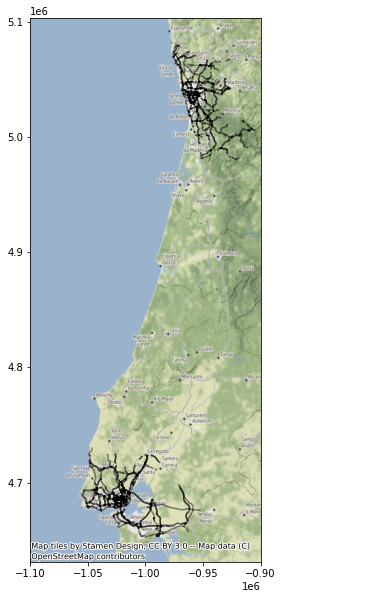

In [6]:
# Visualize the road_risks in the map
ax = risk_roads.plot(figsize=(20,10), alpha=0.5, edgecolor='k')
ax.set_xlim(-1100000, -900000)
ctx.add_basemap(ax)

In [7]:
risk_roads.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34678 entries, 0 to 34677
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Link_ID     34678 non-null  int64   
 1   linkid      34678 non-null  int64   
 2   Daily_Aver  34678 non-null  float64 
 3   Average_Ve  34678 non-null  float64 
 4   Median_of_  34678 non-null  float64 
 5   First_Quar  34678 non-null  float64 
 6   Third_Quar  34678 non-null  float64 
 7   Func_Class  34678 non-null  int64   
 8   Speed_Cat   34678 non-null  int64   
 9   geometry    34678 non-null  geometry
dtypes: float64(5), geometry(1), int64(4)
memory usage: 2.6 MB


## Metrics extraction

### **exceeds_cat_limit** & **third_quar_proportion_exceeds**

This metric will evaluate the proportion that the third quartile of velocity exceeds the speed category upper limit.

In [8]:
limit_df = pd.DataFrame(
    {
        "Speed_Cat": [1,2,3,4,5,6,7,8], 
        "Limit": [200, 130, 100, 90, 70, 50, 30, 11]
     }
) # first one is 200 because it doesn't have an upper limit and no speed should exceed it.

risk_roads = risk_roads.merge(limit_df, how="left", on="Speed_Cat")
risk_roads.head()

,Link_ID,linkid,Daily_Aver,Average_Ve,Median_of_,First_Quar,Third_Quar,Func_Class,Speed_Cat,geometry,Limit
0,80216819,80216819,6224.778569,45.208716,44.464286,28.000000,59.00,2,6,"LINESTRING (-1020134.040 4688822.224, -1020119...",50
1,80216858,80216858,2236.054168,79.563308,82.750000,71.750000,93.25,2,4,"LINESTRING (-1020404.546 4684887.993, -1020396...",90
2,80216859,80216859,2138.725039,65.955069,67.333333,61.000000,75.00,3,6,"LINESTRING (-1020404.546 4684887.993, -1020395...",50
3,80216860,80216860,2201.335041,47.533911,44.000000,26.900000,74.00,3,6,"LINESTRING (-1020341.094 4685025.009, -1020318...",50
4,80216867,80216867,2102.610278,51.375291,53.250000,45.333333,59.00,3,6,"LINESTRING (-1020211.964 4685179.154, -1020228...",50


In [9]:
risk_roads['exceeds_cat_limit'] = risk_roads.apply(lambda x: 1 if x['Median_of_']>x['Limit'] else 0, axis=1)
risk_roads['third_quar_proportion_exceeds'] = risk_roads.apply(lambda x: x['Third_Quar'] / x['Limit'], axis=1)
risk_roads.head()

,Link_ID,linkid,Daily_Aver,Average_Ve,Median_of_,First_Quar,Third_Quar,Func_Class,Speed_Cat,geometry,Limit,exceeds_cat_limit,third_quar_proportion_exceeds
0,80216819,80216819,6224.778569,45.208716,44.464286,28.000000,59.00,2,6,"LINESTRING (-1020134.040 4688822.224, -1020119...",50,0,1.180000
1,80216858,80216858,2236.054168,79.563308,82.750000,71.750000,93.25,2,4,"LINESTRING (-1020404.546 4684887.993, -1020396...",90,0,1.036111
2,80216859,80216859,2138.725039,65.955069,67.333333,61.000000,75.00,3,6,"LINESTRING (-1020404.546 4684887.993, -1020395...",50,1,1.500000
3,80216860,80216860,2201.335041,47.533911,44.000000,26.900000,74.00,3,6,"LINESTRING (-1020341.094 4685025.009, -1020318...",50,0,1.480000
4,80216867,80216867,2102.610278,51.375291,53.250000,45.333333,59.00,3,6,"LINESTRING (-1020211.964 4685179.154, -1020228...",50,1,1.180000


### **population_density** and **rainfall_per_day**

To get the population_density and rainfall_per_day we have to;
1. Intersect roads with parishes so we can get different segments and associate a different road risk with it;
2. Calculate population density for each of the counties;
3. Add rainfall data to each of the parishes in parishes data;
4. Merge rainfall and population density data.

The data used here comes from:
1. **[Rainfall and Raindays](https://github.com/Gustavo-SF/WDL-Public-Transportation/blob/main/data/rainfall.csv)** scrapped from [WeatherOnline](https://www.worldweatheronline.com/)
2. **[Parishes Geographical Data](http://mapas.dgterritorio.pt/ATOM-download/CAOP-Cont/Cont_AAD_CAOP2020.zip)**
3. **[Population of Portugal 2019](https://www.ine.pt/xportal/xmain?xpid=INE&xpgid=ine_indicadores&contecto=pi&indOcorrCod=0008273&selTab=tab0)**

In [10]:
# Load needed data

# Population Data
pop = pd.read_csv('data/2019_population_by_county_age_and_sex.csv', sep=';', encoding='ISO-8859-1')

# Parishes Geographical Data
parishes = gpd.read_file('data/Parishes.json')

# Rainfall and Raindays for each county
rainfall = pd.read_csv('data/rainfall.csv')

In [11]:
# Load the Parishes Geopandas file
parishes = parishes.set_crs(epsg=3763, allow_override=True)

# Get Geopandas df for counties
county = parishes.dissolve(by=['Concelho']).reset_index()[['Distrito', 'Concelho', 'geometry']]
county = county[(county.Distrito=='Porto') | (county.Distrito=='Lisboa')]
county.head()

,Distrito,Concelho,geometry
10,Lisboa,Alenquer,"POLYGON ((-71541.837 -69268.209, -71565.006 -6..."
23,Lisboa,Amadora,"POLYGON ((-93224.566 -102469.211, -93221.405 -..."
24,Porto,Amarante,"POLYGON ((9463.543 170406.813, 9453.013 170403..."
34,Lisboa,Arruda dos Vinhos,"POLYGON ((-84678.825 -75480.365, -84662.076 -7..."
37,Lisboa,Azambuja,"POLYGON ((-65512.623 -70413.580, -65594.219 -7..."


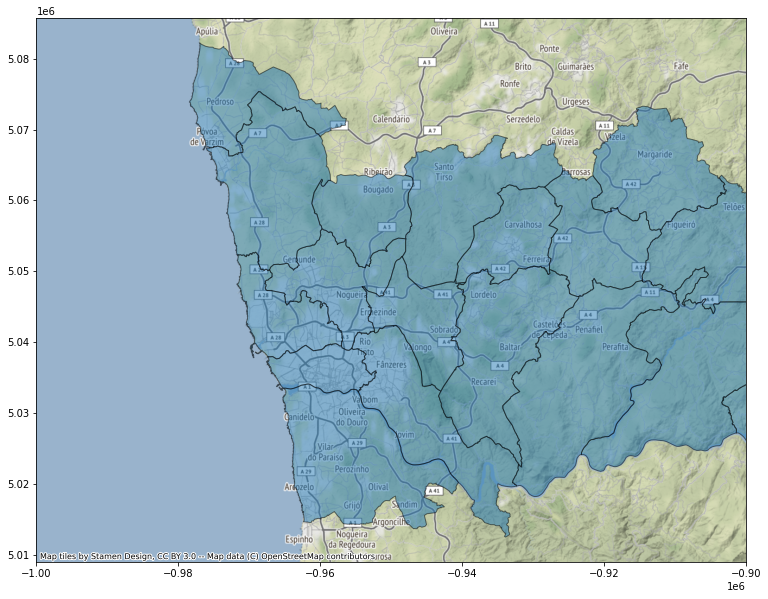

In [12]:
county = county.to_crs(epsg=3857)

# Visualize the parishes in Porto as an example
ax = county[county['Distrito']=='Porto'].plot(figsize=(20,10), alpha=0.5, edgecolor='k')
ax.set_xlim(-1000000, -900000)
ctx.add_basemap(ax)

In [13]:
# cross join both tables to get different road segments for different counties
county['key'] = 1
risk_roads['key'] = 1
risk_roads = risk_roads.merge(county.rename(columns={'geometry': 'county_polygon'}), on='key')

# should take a while to run
risk_roads['road_segment_linestring'] = risk_roads['geometry'].intersection(risk_roads['county_polygon'])
risk_roads.head()

,Link_ID,linkid,Daily_Aver,Average_Ve,Median_of_,First_Quar,Third_Quar,Func_Class,Speed_Cat,geometry,Limit,exceeds_cat_limit,third_quar_proportion_exceeds,key,Distrito,Concelho,county_polygon,road_segment_linestring
0,80216819,80216819,6224.778569,45.208716,44.464286,28.0,59.0,2,6,"LINESTRING (-1020134.040 4688822.224, -1020119...",50,0,1.18,1,Lisboa,Alenquer,"POLYGON ((-997361.494 4727606.152, -997391.223...",LINESTRING EMPTY
1,80216819,80216819,6224.778569,45.208716,44.464286,28.0,59.0,2,6,"LINESTRING (-1020134.040 4688822.224, -1020119...",50,0,1.18,1,Lisboa,Amadora,"POLYGON ((-1024735.413 4684547.765, -1024730.7...",LINESTRING EMPTY
2,80216819,80216819,6224.778569,45.208716,44.464286,28.0,59.0,2,6,"LINESTRING (-1020134.040 4688822.224, -1020119...",50,0,1.18,1,Porto,Amarante,"POLYGON ((-892813.664 5042301.496, -892827.644...",LINESTRING EMPTY
3,80216819,80216819,6224.778569,45.208716,44.464286,28.0,59.0,2,6,"LINESTRING (-1020134.040 4688822.224, -1020119...",50,0,1.18,1,Lisboa,Arruda dos Vinhos,"POLYGON ((-1014165.070 4719422.300, -1014143.6...",LINESTRING EMPTY
4,80216819,80216819,6224.778569,45.208716,44.464286,28.0,59.0,2,6,"LINESTRING (-1020134.040 4688822.224, -1020119...",50,0,1.18,1,Lisboa,Azambuja,"POLYGON ((-989597.583 4726195.402, -989699.821...",LINESTRING EMPTY


In [14]:
risk_roads = risk_roads[~risk_roads.road_segment_linestring.is_empty]

In [15]:
risk_roads = risk_roads.set_geometry('road_segment_linestring')

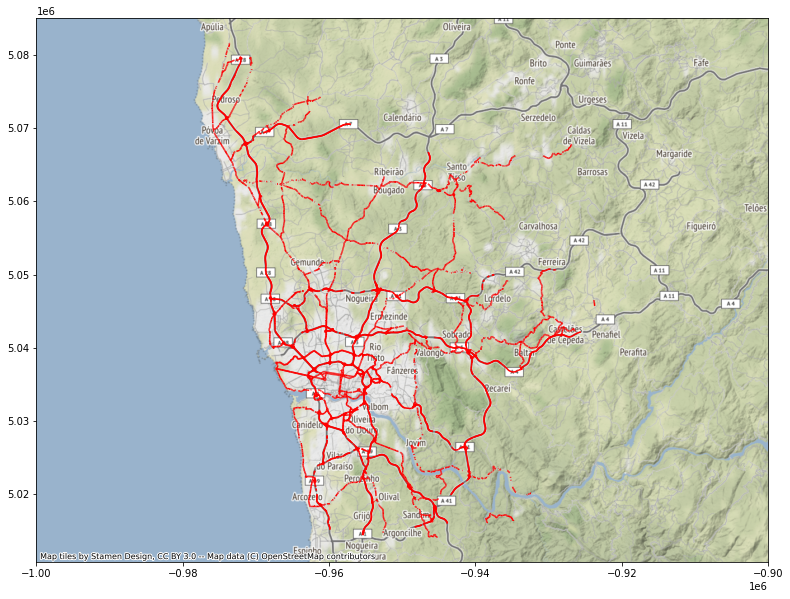

In [16]:
# checking if it worked
# Visualize the district if Porto as an example
ax = risk_roads[risk_roads['Distrito']=='Porto'].plot(figsize=(20,10), edgecolor='r')
ax.set_xlim(-1000000, -900000)
ctx.add_basemap(ax)

In [24]:
pop.head()

,Período de referência dos dados,Local de residência (NUTS - 2013) (1),"População residente (N.º) por Local de residência (NUTS - 2013), Sexo e Grupo etário - Anual (2)",Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59
0,NaN,NaN,Sexo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,HM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,Grupo etário,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,Total,0 - 4 anos,5 - 9 anos,10 - 14 anos,15 - 19 anos,20 - 24 anos,25 - 29 anos,30 - 34 anos,35 - 39 anos,40 - 44 anos,45 - 49 anos,50 - 54 anos,55 - 59 anos,60 - 64 anos,65 - 69 anos,70 - 74 anos,75 - 79 anos,80 - 84 anos,85 e mais anos,Total,0 - 4 anos,5 - 9 anos,10 - 14 anos,15 - 19 anos,20 - 24 anos,25 - 29 anos,30 - 34 anos,35 - 39 anos,40 - 44 anos,45 - 49 anos,50 - 54 anos,55 - 59 anos,60 - 64 anos,65 - 69 anos,70 - 74 anos,75 - 79 anos,80 - 84 anos,85 e mais anos,Total,0 - 4 anos,5 - 9 anos,10 - 14 anos,15 - 19 anos,20 - 24 anos,25 - 29 anos,30 - 34 anos,35 - 39 anos,40 - 44 anos,45 - 49 anos,50 - 54 anos,55 - 59 anos,60 - 64 anos,65 - 69 anos,70 - 74 anos,75 - 79 anos,80 - 84 anos,85 e mais anos,NaN
4,NaN,NaN,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,N.º,NaN


In [25]:
ln = 19
cols = ['Location'] + list(pop.iloc[3, 2:-1])
pop = pop.iloc[5:348,1:-1]
pop.columns = cols
pop.head()

,Location,Total,0 - 4 anos,5 - 9 anos,10 - 14 anos,15 - 19 anos,20 - 24 anos,25 - 29 anos,30 - 34 anos,35 - 39 anos,40 - 44 anos,45 - 49 anos,50 - 54 anos,55 - 59 anos,60 - 64 anos,65 - 69 anos,70 - 74 anos,75 - 79 anos,80 - 84 anos,85 e mais anos,Total,0 - 4 anos,5 - 9 anos,10 - 14 anos,15 - 19 anos,20 - 24 anos,25 - 29 anos,30 - 34 anos,35 - 39 anos,40 - 44 anos,45 - 49 anos,50 - 54 anos,55 - 59 anos,60 - 64 anos,65 - 69 anos,70 - 74 anos,75 - 79 anos,80 - 84 anos,85 e mais anos,Total,0 - 4 anos,5 - 9 anos,10 - 14 anos,15 - 19 anos,20 - 24 anos,25 - 29 anos,30 - 34 anos,35 - 39 anos,40 - 44 anos,45 - 49 anos,50 - 54 anos,55 - 59 anos,60 - 64 anos,65 - 69 anos,70 - 74 anos,75 - 79 anos,80 - 84 anos,85 e mais anos
5,PT: Portugal,10295909,436202,455843,504940,545322,550444,547680,566594,672422,784224,789733,745178,740141,676762,622912,549591,432058,353254,322609,4859977,222777,232942,257758,278552,278859,273076,278699,323038,374062,374161,351817,346645,314248,285465,243388,181794,137793,104903,5435932,213425,222901,247182,266770,271585,274604,287895,349384,410162,415572,393361,393496,362514,337447,306203,250264,215461,217706
6,1: Continente,9798859,415473,432930,477944,514548,518764,514892,533486,636213,743545,750792,708497,703737,647068,597684,530304,417242,342218,313522,4623424,212124,221262,243942,262915,262559,256542,261816,305129,354199,355485,334490,329905,300740,273849,235425,176368,134243,102431,5175435,203349,211668,234002,251633,256205,258350,271670,331084,389346,395307,374007,373832,346328,323835,294879,240874,207975,211091
7,11: Norte,3575338,138522,145676,167426,193356,202305,199661,201137,233246,268279,280939,274571,275921,245514,218242,182316,136239,112356,99632,1687717,70744,74481,85045,98446,102901,99715,98713,111638,127432,131767,127920,129218,114317,100263,81289,57476,43718,32634,1887621,67778,71195,82381,94910,99404,99946,102424,121608,140847,149172,146651,146703,131197,117979,101027,78763,68638,66998
8,111: Alto Minho,230412,7784,8234,9839,11483,12018,12305,12593,14657,16405,17032,16453,17072,16165,14333,12748,10936,10251,10104,106605,3942,4175,5036,5874,6202,6201,6294,7047,7828,8056,7479,7854,7452,6456,5284,4375,3764,3286,123807,3842,4059,4803,5609,5816,6104,6299,7610,8577,8976,8974,9218,8713,7877,7464,6561,6487,6818
9,1111601: Arcos de Valdevez,20926,563,657,774,963,981,1048,1082,1258,1248,1333,1262,1512,1438,1329,1338,1282,1343,1515,9449,262,340,392,522,494,513,545,635,618,646,595,677,648,547,498,494,472,551,11477,301,317,382,441,487,535,537,623,630,687,667,835,790,782,840,788,871,964


In [26]:
pop = pop.iloc[:,:2]
pop['County'] = pop['Location'].apply(lambda x: x.split(': ')[1])
pop = pop[['County', 'Total']]
pop.head()

,County,Total
5,Portugal,10295909
6,Continente,9798859
7,Norte,3575338
8,Alto Minho,230412
9,Arcos de Valdevez,20926


In [27]:
pop = pop[pop.County.isin(risk_roads.Concelho.unique())]
print(f"There are {pop.duplicated(subset=['County']).sum()} duplicates in the population dataset")

There are 0 duplicates in the population dataset


In [28]:
risk_roads_temp = risk_roads.merge(pop, left_on=['Concelho'], right_on=['County'])
risk_roads_temp.head()

,Link_ID,linkid,Daily_Aver,Average_Ve,Median_of_,First_Quar,Third_Quar,Func_Class,Speed_Cat,geometry,Limit,exceeds_cat_limit,third_quar_proportion_exceeds,key,Distrito,Concelho,county_polygon,road_segment_linestring,County,Total
0,80216819,80216819,6224.778569,45.208716,44.464286,28.000000,59.00,2,6,"LINESTRING (-1020134.040 4688822.224, -1020119...",50,0,1.180000,1,Lisboa,Lisboa,"POLYGON ((-1022573.813 4677586.874, -1022933.0...","LINESTRING (-1020134.040 4688822.224, -1020119...",Lisboa,509515
1,80216858,80216858,2236.054168,79.563308,82.750000,71.750000,93.25,2,4,"LINESTRING (-1020404.546 4684887.993, -1020396...",90,0,1.036111,1,Lisboa,Lisboa,"POLYGON ((-1022573.813 4677586.874, -1022933.0...","LINESTRING (-1020404.546 4684887.993, -1020396...",Lisboa,509515
2,80216859,80216859,2138.725039,65.955069,67.333333,61.000000,75.00,3,6,"LINESTRING (-1020404.546 4684887.993, -1020395...",50,1,1.500000,1,Lisboa,Lisboa,"POLYGON ((-1022573.813 4677586.874, -1022933.0...","LINESTRING (-1020404.546 4684887.993, -1020395...",Lisboa,509515
3,80216860,80216860,2201.335041,47.533911,44.000000,26.900000,74.00,3,6,"LINESTRING (-1020341.094 4685025.009, -1020318...",50,0,1.480000,1,Lisboa,Lisboa,"POLYGON ((-1022573.813 4677586.874, -1022933.0...","LINESTRING (-1020341.094 4685025.009, -1020318...",Lisboa,509515
4,80216867,80216867,2102.610278,51.375291,53.250000,45.333333,59.00,3,6,"LINESTRING (-1020211.964 4685179.154, -1020228...",50,1,1.180000,1,Lisboa,Lisboa,"POLYGON ((-1022573.813 4677586.874, -1022933.0...","LINESTRING (-1020211.964 4685179.154, -1020228...",Lisboa,509515


In [29]:
risk_roads_temp['county_area'] = risk_roads_temp['county_polygon'].area / 10**6 # in square km
risk_roads_temp['population_density'] = risk_roads_temp['Total'].astype(int) / risk_roads_temp['county_area']
risk_roads_temp.head()

,Link_ID,linkid,Daily_Aver,Average_Ve,Median_of_,First_Quar,Third_Quar,Func_Class,Speed_Cat,geometry,Limit,exceeds_cat_limit,third_quar_proportion_exceeds,key,Distrito,Concelho,county_polygon,road_segment_linestring,County,Total,county_area,population_density
0,80216819,80216819,6224.778569,45.208716,44.464286,28.000000,59.00,2,6,"LINESTRING (-1020134.040 4688822.224, -1020119...",50,0,1.180000,1,Lisboa,Lisboa,"POLYGON ((-1022573.813 4677586.874, -1022933.0...","LINESTRING (-1020134.040 4688822.224, -1020119...",Lisboa,509515,164.656249,3094.416424
1,80216858,80216858,2236.054168,79.563308,82.750000,71.750000,93.25,2,4,"LINESTRING (-1020404.546 4684887.993, -1020396...",90,0,1.036111,1,Lisboa,Lisboa,"POLYGON ((-1022573.813 4677586.874, -1022933.0...","LINESTRING (-1020404.546 4684887.993, -1020396...",Lisboa,509515,164.656249,3094.416424
2,80216859,80216859,2138.725039,65.955069,67.333333,61.000000,75.00,3,6,"LINESTRING (-1020404.546 4684887.993, -1020395...",50,1,1.500000,1,Lisboa,Lisboa,"POLYGON ((-1022573.813 4677586.874, -1022933.0...","LINESTRING (-1020404.546 4684887.993, -1020395...",Lisboa,509515,164.656249,3094.416424
3,80216860,80216860,2201.335041,47.533911,44.000000,26.900000,74.00,3,6,"LINESTRING (-1020341.094 4685025.009, -1020318...",50,0,1.480000,1,Lisboa,Lisboa,"POLYGON ((-1022573.813 4677586.874, -1022933.0...","LINESTRING (-1020341.094 4685025.009, -1020318...",Lisboa,509515,164.656249,3094.416424
4,80216867,80216867,2102.610278,51.375291,53.250000,45.333333,59.00,3,6,"LINESTRING (-1020211.964 4685179.154, -1020228...",50,1,1.180000,1,Lisboa,Lisboa,"POLYGON ((-1022573.813 4677586.874, -1022933.0...","LINESTRING (-1020211.964 4685179.154, -1020228...",Lisboa,509515,164.656249,3094.416424


### Rainfall

Now we can also add the rainfall per day data

In [30]:
rainfall.head()

,county,month,rainfall,raindays
0,Lisboa,09/2019,11.4,4
1,Lisboa,10/2019,43.2,12
2,Lisboa,11/2019,114.9,27
3,Lisboa,12/2019,110.0,12
4,Lisboa,01/2020,65.6,17


In [31]:
print(rainfall.month.unique())

# We have data from 9/2019 to 03/2021. We will try to obtain rainfall per day for each county

rainfall.drop(columns=['month', 'raindays'], inplace=True) # we will drop raindays since it is less relevant

rain_grouped = rainfall.groupby(by=['county']).sum().reset_index()
rain_grouped.head()

['09/2019' '10/2019' '11/2019' '12/2019' '01/2020' '02/2020' '03/2020'
 '04/2020' '05/2020' '06/2020' '07/2020' '08/2020' '09/2020' '10/2020'
 '11/2020' '12/2020' '01/2021' '02/2021' '03/2021']


,county,rainfall
0,Alcochete,678.9
1,Almada,492.1
2,Amadora,1275.6
3,Arouca,2880.8
4,Barreiro,492.1


In [32]:
# Divide the rainfall and raindays by the number of days
Sept19Mar21  = (datetime(2021,3,31)-datetime(2019,9,1)).days
rain_grouped['rainfall_per_day'] = rain_grouped['rainfall'] / Sept19Mar21
rain_grouped.head()

,county,rainfall,rainfall_per_day
0,Alcochete,678.9,1.176603
1,Almada,492.1,0.852860
2,Amadora,1275.6,2.210745
3,Arouca,2880.8,4.992721
4,Barreiro,492.1,0.852860


In [33]:
risk_roads = risk_roads_temp.merge(rain_grouped[['county', 'rainfall_per_day']], left_on='Concelho', right_on='county')

# clean dataset

risk_roads = risk_roads[['Distrito', 'County', 'Link_ID', 'Daily_Aver', 'Func_Class', 'road_segment_linestring', 'exceeds_cat_limit', 'third_quar_proportion_exceeds', 'population_density', 'rainfall_per_day']]
risk_roads.head()

,Distrito,County,Link_ID,Daily_Aver,Func_Class,road_segment_linestring,exceeds_cat_limit,third_quar_proportion_exceeds,population_density,rainfall_per_day
0,Lisboa,Lisboa,80216819,6224.778569,2,"LINESTRING (-1020134.040 4688822.224, -1020119...",0,1.180000,3094.416424,2.016984
1,Lisboa,Lisboa,80216858,2236.054168,2,"LINESTRING (-1020404.546 4684887.993, -1020396...",0,1.036111,3094.416424,2.016984
2,Lisboa,Lisboa,80216859,2138.725039,3,"LINESTRING (-1020404.546 4684887.993, -1020395...",1,1.500000,3094.416424,2.016984
3,Lisboa,Lisboa,80216860,2201.335041,3,"LINESTRING (-1020341.094 4685025.009, -1020318...",0,1.480000,3094.416424,2.016984
4,Lisboa,Lisboa,80216867,2102.610278,3,"LINESTRING (-1020211.964 4685179.154, -1020228...",1,1.180000,3094.416424,2.016984


### **has_roundabout**

To get the roundabours_per_km and intersections_per_km we have to;
1. Load the OSM information;
2. Find the rows containing roundabouts;
3. Union all of the data;
4. Buffer the roads by a few meters;
5. Intersect the roads with the points to know if they have roundabouts or not.

The data used here comes from:
1. **[Each County Public Street Data](https://nominatim.openstreetmap.org/ui/search.html)**

In [35]:
ox.config(use_cache=True)
place = 'Porto, Portugal'
nt = 'drive'

cf = '["junction"="roundabout"]'
G = ox.graph_from_place(place, network_type=nt, custom_filter=cf, retain_all=True, simplify=False)
roundabouts = list(nx.weakly_connected_components(G))
len(roundabouts) #60

35

In [36]:
%%time
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

CPU times: user 111 ms, sys: 1 ms, total: 112 ms
Wall time: 114 ms


In [37]:
nodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [38]:
for i in range(len(roundabouts)):
  gdfs = nodes.loc[list(roundabouts[i]),:]
  if i == 0:
    dot = gdfs.geometry.unary_union.centroid
  else:
    dot = dot.union(gdfs.geometry.unary_union.centroid)

In [39]:
new_data = gpd.GeoDataFrame(data={"line_id": 1, "geometry": [dot]}, crs=4326)

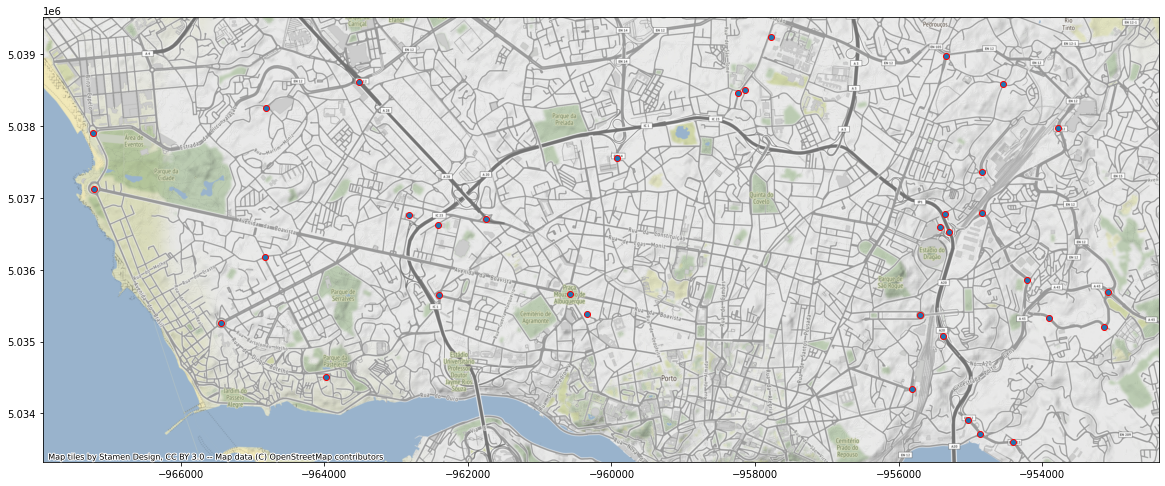

In [40]:
new_data = new_data.to_crs(epsg=3857)
# Visualize the roundabouts in the map
ax = new_data.plot(figsize=(20,10), alpha=1, edgecolor='r')
ctx.add_basemap(ax)

In [41]:
for j, county in enumerate(risk_roads.County.unique()):
  place = f'{county}, Portugal'
  cf = '["junction"="roundabout"]'
  G = ox.graph_from_place(place, network_type=nt, custom_filter=cf, retain_all=True, simplify=False)
  roundabouts = list(nx.weakly_connected_components(G))
  nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
  print(county)
  print(len(roundabouts))
  for i in range(len(roundabouts)):
    gdfs = nodes.loc[list(roundabouts[i]),:]
    if j == 0:
      dot = gdfs.geometry.unary_union.centroid
    else:
      dot = dot.union(gdfs.geometry.unary_union.centroid)

Lisboa
120
Oeiras
123
Loures
26
Mafra
73
Vila Franca de Xira
81
Amadora
100
Odivelas
50
Cascais
201
Sintra
181
Porto
35
Valongo
67
Paredes
12
Gondomar
100
Vila Nova de Gaia
105
Santo Tirso
26
Trofa
24
Póvoa de Varzim
32
Vila do Conde
39
Matosinhos
85
Maia
66


In [42]:
new_data = gpd.GeoDataFrame(data={"line_id": 1, "geometry": [dot]}, crs=4326)

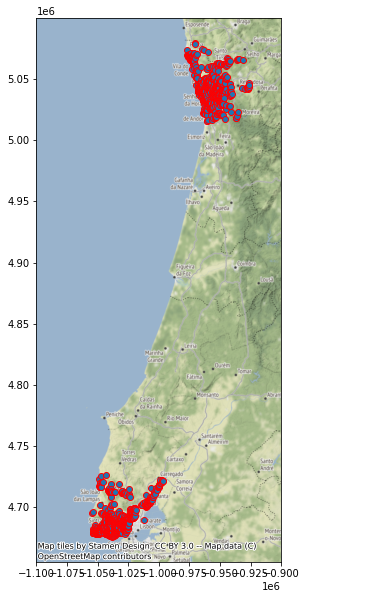

In [43]:
new_data = new_data.to_crs(epsg=3857)
# Visualize the roundabouts in the map
ax = new_data.plot(figsize=(20,10), alpha=1, edgecolor='r')
ax.set_xlim(-1100000, -900000)
ctx.add_basemap(ax)

In [50]:
risk_roads['points_roundabouts_per_km'] = risk_roads['road_segment_linestring'].buffer(15).intersection(new_data['geometry'].unary_union) # 15 meters just for error

In [65]:
def func(x):
    if  x.is_empty:
        return 0
    else:
        return 1

risk_roads['has_roundabout'] = risk_roads['points_roundabouts_per_km'].apply(func)
risk_roads.head()

,Distrito,County,Link_ID,Daily_Aver,Func_Class,road_segment_linestring,exceeds_cat_limit,third_quar_proportion_exceeds,population_density,rainfall_per_day,road_length,points_roundabouts_per_km,roundabouts_per_km,has_roundabout
0,Lisboa,Lisboa,80216819,6224.778569,2,"LINESTRING (-1020134.040 4688822.224, -1020119...",0,1.180000,3094.416424,2.016984,0.096000,POINT EMPTY,0.0,0
1,Lisboa,Lisboa,80216858,2236.054168,2,"LINESTRING (-1020404.546 4684887.993, -1020396...",0,1.036111,3094.416424,2.016984,0.051118,POINT EMPTY,0.0,0
2,Lisboa,Lisboa,80216859,2138.725039,3,"LINESTRING (-1020404.546 4684887.993, -1020395...",1,1.500000,3094.416424,2.016984,0.049224,POINT EMPTY,0.0,0
3,Lisboa,Lisboa,80216860,2201.335041,3,"LINESTRING (-1020341.094 4685025.009, -1020318...",0,1.480000,3094.416424,2.016984,0.153562,POINT EMPTY,0.0,0
4,Lisboa,Lisboa,80216867,2102.610278,3,"LINESTRING (-1020211.964 4685179.154, -1020228...",1,1.180000,3094.416424,2.016984,0.074478,POINT EMPTY,0.0,0


In [66]:
risk_roads[risk_roads.has_roundabout==1]

,Distrito,County,Link_ID,Daily_Aver,Func_Class,road_segment_linestring,exceeds_cat_limit,third_quar_proportion_exceeds,population_density,rainfall_per_day,road_length,points_roundabouts_per_km,roundabouts_per_km,has_roundabout
4940,Lisboa,Oeiras,545363765,7853.978500,3,"LINESTRING (-1032962.498 4685655.876, -1033019...",0,0.922222,2350.976566,1.459792,0.743045,POINT (-1033325.632 4685772.735),1.345814,1
5144,Lisboa,Oeiras,812275631,7687.068532,3,"LINESTRING (-1032974.743 4685641.603, -1033038...",0,0.850000,2350.976566,1.459792,0.733206,POINT (-1033325.632 4685772.735),1.363873,1
5879,Lisboa,Loures,542424615,2424.357363,3,"LINESTRING (-1020040.532 4696866.717, -1020042...",0,0.860000,773.749261,2.016984,0.024376,POINT (-1020035.638 4696873.467),41.023722,1
5881,Lisboa,Loures,542424617,1664.481925,3,"LINESTRING (-1020016.041 4696882.435, -1020018...",0,1.000000,773.749261,2.016984,0.023964,POINT (-1020035.638 4696873.467),41.729442,1
5882,Lisboa,Loures,542424618,2276.498158,3,"LINESTRING (-1020021.607 4696862.430, -1020027...",0,0.880000,773.749261,2.016984,0.021057,POINT (-1020035.638 4696873.467),47.491086,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26260,Porto,Matosinhos,868643839,3914.752399,2,"LINESTRING (-957332.036 5041663.125, -957375.4...",0,0.753846,1588.461229,4.400867,0.045866,POINT (-957348.101 5041683.373),21.802545,1
26633,Porto,Matosinhos,1172987110,12024.652661,2,"LINESTRING (-963521.650 5038641.913, -963551.4...",0,0.966667,1588.461229,4.400867,0.043498,POINT (-963531.557 5038663.353),22.989360,1
27013,Porto,Maia,717596743,2552.118390,3,"LINESTRING (-959218.901 5049994.601, -959214.4...",1,1.280000,946.480312,4.400867,0.026349,POINT (-959206.830 5049987.164),37.952587,1
27014,Porto,Maia,717596744,3805.780231,3,"LINESTRING (-959197.751 5049962.024, -959204.4...",1,1.420000,946.480312,4.400867,0.048886,POINT (-959206.830 5049987.164),20.455714,1


We also tried to count roundabouts and get the roundabouts per day, but with very small segments, we would get 40 roundabouts per km for very small segments of road. Therefore we decided to just create the 'has_roundabout' column

## Creating the heatmap

To finalize we set the weights we provide to each of these variables for each of the types of roads (FRC1, FRC2, FRC3):

1. Traffic daily average
2. If the median velocity exceeds the upper bound of speed category
3. By how much proportion does the third quartile of velocity exceeds the upper bound of speed category
4. Population density of the county the road is in
5. Rainfall per day of the county the road is in
6. If the road has a roundabout or not

In [89]:
data = risk_roads[['Distrito', 'County', 'Daily_Aver', 'Func_Class', 'road_segment_linestring', 'exceeds_cat_limit', 'third_quar_proportion_exceeds', 'population_density', 'rainfall_per_day', 'has_roundabout']].copy()

In [90]:
data.head()

,Distrito,County,Daily_Aver,Func_Class,road_segment_linestring,exceeds_cat_limit,third_quar_proportion_exceeds,population_density,rainfall_per_day,has_roundabout
0,Lisboa,Lisboa,6224.778569,2,"LINESTRING (-1020134.040 4688822.224, -1020119...",0,1.180000,3094.416424,2.016984,0
1,Lisboa,Lisboa,2236.054168,2,"LINESTRING (-1020404.546 4684887.993, -1020396...",0,1.036111,3094.416424,2.016984,0
2,Lisboa,Lisboa,2138.725039,3,"LINESTRING (-1020404.546 4684887.993, -1020395...",1,1.500000,3094.416424,2.016984,0
3,Lisboa,Lisboa,2201.335041,3,"LINESTRING (-1020341.094 4685025.009, -1020318...",0,1.480000,3094.416424,2.016984,0
4,Lisboa,Lisboa,2102.610278,3,"LINESTRING (-1020211.964 4685179.154, -1020228...",1,1.180000,3094.416424,2.016984,0


In [92]:
from sklearn import preprocessing

list_of_variables=["population_density", "rainfall_per_day", "Daily_Aver", "exceeds_cat_limit", "third_quar_proportion_exceeds", "has_roundabout"]
# Normalization
for i in range(len(list_of_variables)):
  x = data.loc[:,list_of_variables[i]]
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(np.asarray(x).reshape(-1,1))
  data[list_of_variables[i]] = x_scaled

In [94]:
list_of_variables=["population_density", "rainfall_per_day", "Daily_Aver", "exceeds_cat_limit", "third_quar_proportion_exceeds", "has_roundabout"]

# INPUT THE WEIGHTS HERE!!!
# Positive numbers increase the risk and negatives decrease

weight = [-0.1,0.3,0.4,0.7,1,-1]  # Example

def risk(df,list_of_variables,list_of_weights):
  #list_of_weights=np.array(list_of_weights)

  if len(list_of_weights)!=len(list_of_variables):
    print("Lists not of the same size")
    return None

  mat=df[list_of_variables].dot(list_of_weights)
  df['score']=mat
  return df

In [95]:
r = risk(data, list_of_variables, weights)
r.head()

,Distrito,County,Daily_Aver,Func_Class,road_segment_linestring,exceeds_cat_limit,third_quar_proportion_exceeds,population_density,rainfall_per_day,has_roundabout,score
0,Lisboa,Lisboa,0.125541,2,"LINESTRING (-1020134.040 4688822.224, -1020119...",0.0,0.038808,0.64501,0.166932,0.0,0.191377
1,Lisboa,Lisboa,0.044585,2,"LINESTRING (-1020404.546 4684887.993, -1020396...",0.0,0.033822,0.64501,0.166932,0.0,0.174688
2,Lisboa,Lisboa,0.042610,3,"LINESTRING (-1020404.546 4684887.993, -1020395...",1.0,0.049896,0.64501,0.166932,0.0,0.375900
3,Lisboa,Lisboa,0.043880,3,"LINESTRING (-1020341.094 4685025.009, -1020318...",0.0,0.049203,0.64501,0.166932,0.0,0.176085
4,Lisboa,Lisboa,0.041877,3,"LINESTRING (-1020211.964 4685179.154, -1020228...",1.0,0.038808,0.64501,0.166932,0.0,0.374644


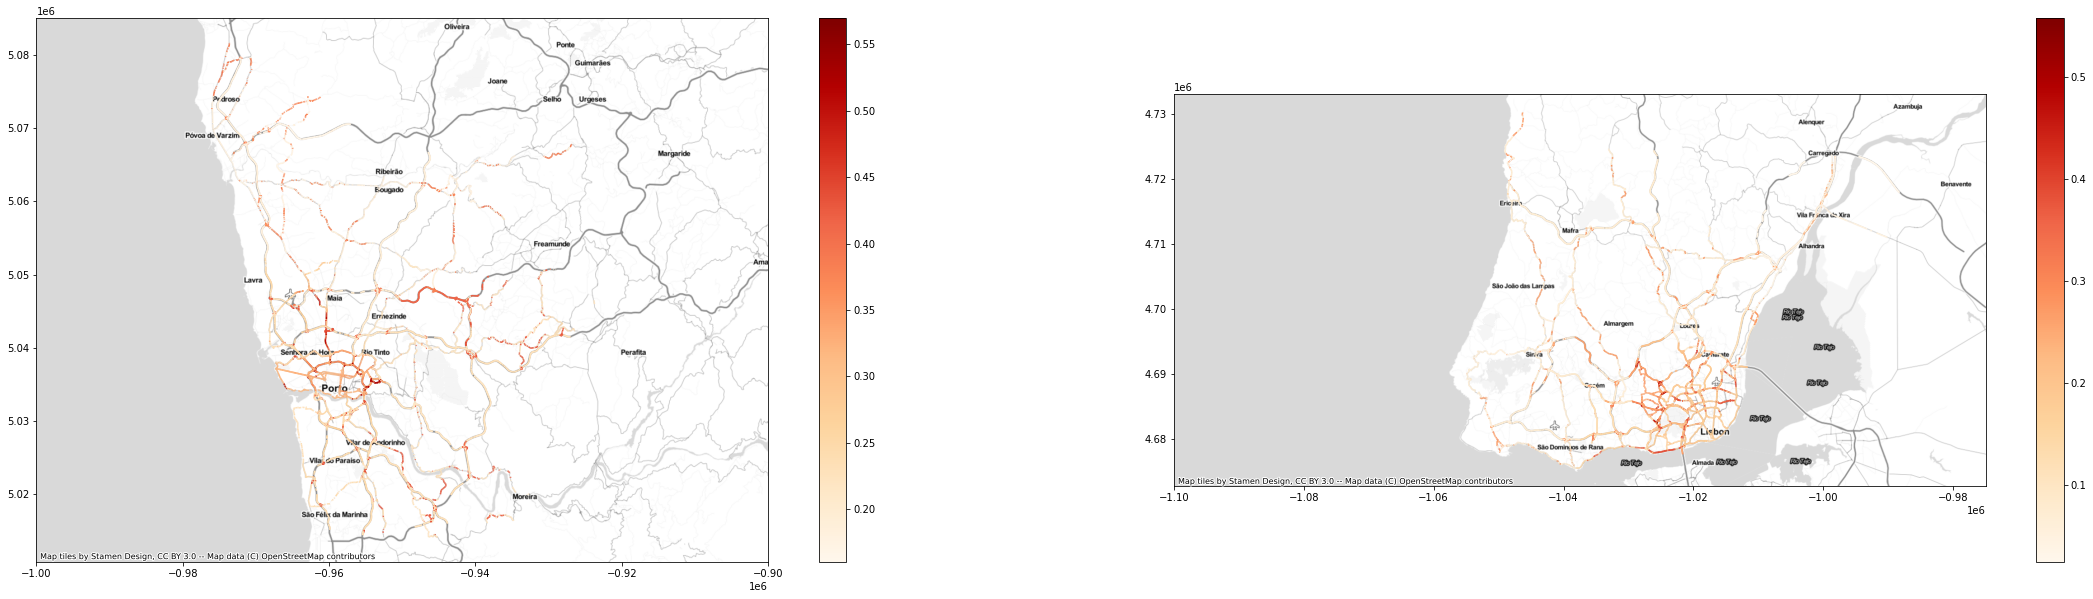

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(40,10))
ax = r[r.Distrito=='Porto'].plot(column='score', ax=axes[0], legend=True, cmap='OrRd')
ax.set_xlim(-1000000, -900000)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax = r[r.Distrito=='Lisboa'].plot(column='score', ax=axes[1], legend=True, cmap='OrRd')
ax.set_xlim(-1100000, -975000)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

## Conclusions

### Scalability and Impact

There are several limitations with this work. We have especially suffered from lack of data to know variable importance and analyse patterns for risk. 

With this work we are providing the user a tool to customize the weights for each variable and test for variable impact. Since we did not have the data to measure variable importance for evaluating road risk, this work only allows to provide a tool with which to test hypothesis and see if the predicted risk is validated by reality.

This tools also allows to investigate each of the variables if we provide weights of 1 to the one we want to investigate and 0 to the rest. It is a simple model but should already support a lot of investigation.

We should take in mind that we can assign negative weights as well.



### Future Work

We only had county data we could make use of for population density and rainfall. Since we have roads that are in the border of counties, we finished with a lot of segmented roads where we could hardly say which population density we could assign to it. This could definitely be worked on.

We also wanted to get intersections since it is a very important factor for risk assessment. To get this we could intersect each of the roads with the rest and count the points we get.

We could also assign different weights according to the type of road. This would be indicated, since highways, for example have different factors that we should take into consideration.